<a href="https://colab.research.google.com/github/NARAEIM/tp2-da/blob/imnarae/tp2_lightgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lightgbm

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [30]:
df = pd.read_csv('/content/feature_target(5-7).csv')
df = df.drop_duplicates()
df = df.drop(['first_join_date','gender'], axis=1)

# 'revisit' 컬럼 : timedelta -> 초 변환
df['revisit'] = pd.to_timedelta(df['revisit']).dt.total_seconds()


In [31]:
# RFM SEGMENT 각각 분리

df['RFM_Segment'] = df['RFM_Segment'].astype(str)
df['R'] = df['RFM_Segment'].str[0].astype(int)
df['F'] = df['RFM_Segment'].str[1].astype(int)
df['M'] = df['RFM_Segment'].str[2].astype(int)

df = df.drop(['RFM_Segment'], axis=1)


In [32]:
# Ordinal 인코딩
ordinal_encoder = OrdinalEncoder()
df_encoded = ordinal_encoder.fit_transform(df)
df_encoded = pd.DataFrame(df_encoded, columns=df.columns)


In [33]:
X = df_encoded.drop(['bounce', 'customer_id'], axis=1)
y = df_encoded['bounce']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['bounce'])

In [13]:
# # 업샘플링
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(random_state=42)
# X_train_over, y__train_over = ros.fit_resample(X_train, y_train)

In [ ]:
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# model = lgb.LGBMClassifier(n_estimators=500,  learning_rate=0.05, colsample_bytree=0.8, lambda_l1=0.3, lambda_l2=0.2,
#                            max_depth=13, min_child_samples=15, subsample=0.7, class_weight='balanced',
#                            random_state=42)

In [36]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# lgbm_model = LGBMClassifier(n_estimators=500, learning_rate=0.05, random_state=42)
# lgbm_model.fit(X_res, y_res)

lgbm_model = lgb.LGBMClassifier(n_estimators=500,  learning_rate=0.05, colsample_bytree=0.8, lambda_l1=0.3, lambda_l2=0.2,
                           max_depth=13, min_child_samples=15, subsample=0.7, class_weight='balanced',
                           random_state=42)
lgbm_model.fit(X_res, y_res)

# 예측
y_pred = lgbm_model.predict(X_test)

# 성능 평가
print(classification_report(y_test, y_pred))
print("테스트셋 정확도:", accuracy_score(y_test, y_pred))

# 훈련 데이터에 대한 예측
y_train_pred = lgbm_model.predict(X_train)

# 훈련 데이터에 대한 정확도 계산
print("학습데이터셋 정확도:", accuracy_score(y_train, y_train_pred))

[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
              precision    recall  f1-score   support

         0.0       0.31      0.40      0.35      5327
         1.0       0.75      0.67      0.71     14203

    accuracy                           0.59     19530
   macro avg       0.53      0.53      0.53     19530
weighted avg       0.63      0.59      0.61     19530

테스트셋 정확도: 0.5947772657450077
학습데이터셋 정확도: 0.5992012186535925


테스트셋 ROC-AUC score: 0.534455020191085


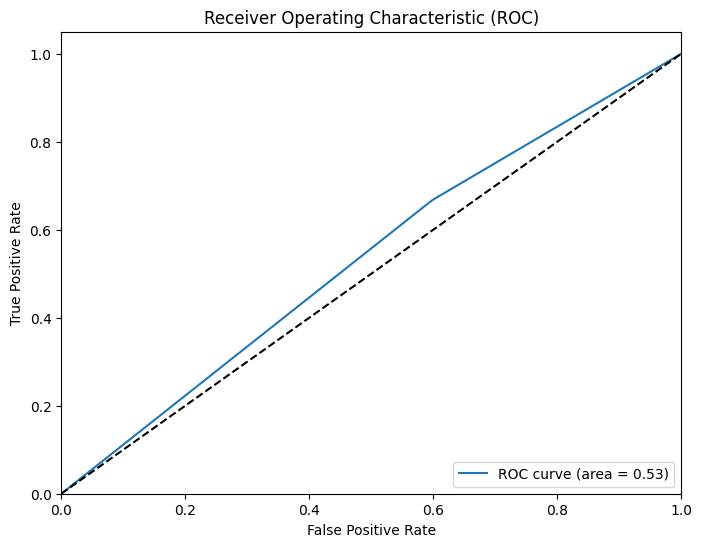

In [35]:
test_roc_auc = roc_auc_score(y_test, y_pred)
print(f"테스트셋 ROC-AUC score: {test_roc_auc}")

fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

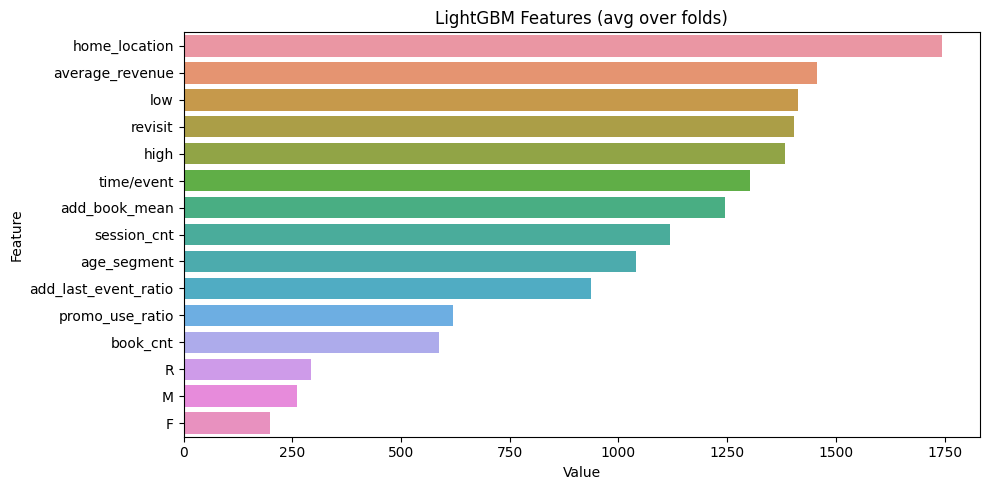

In [37]:
import seaborn as sns

feature_imp = pd.DataFrame(sorted(zip(lgbm_model.feature_importances_,X.columns)), columns=['Value','Feature'])

# Visualize feature importances
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
